In [1]:
%matplotlib inline


# Probability forecasts

This example script shows how to forecast the probability of exceeding an
intensity threshold.

The method is based on the local Lagrangian approach described in Germann and
Zawadzki (2004).


In [2]:
import matplotlib.pyplot as plt
import numpy as np

from pysteps.nowcasts.lagrangian_probability import forecast
from pysteps.visualization import plot_precip_field

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Numerical example

First, we use some dummy data to show the basic principle of this approach.
The probability forecast is produced by sampling a spatial neighborhood that is
increased as a function of lead time. As a result, the edges of
the yellow square becomes more and more smooth as t increases. This represents
the strong loss of predictability with lead time of any extrapolation nowcast.



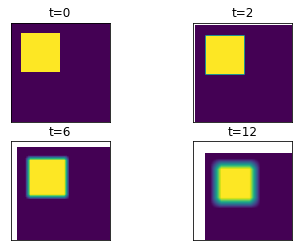

In [3]:
# parameters
precip = np.zeros((100, 100))
precip[10:50, 10:50] = 1
velocity = np.ones((2, *precip.shape))
timesteps = [0, 2, 6, 12]
thr = 0.5
slope = 1  # pixels / timestep

# compute probability forecast
out = forecast(precip, velocity, timesteps, thr, slope=slope)
# plot
for n, frame in enumerate(out):
    plt.subplot(2, 2, n + 1)
    plt.imshow(frame, interpolation="nearest", vmin=0, vmax=1)
    plt.title(f"t={timesteps[n]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

## Real-data example

We now apply the same method to real data. We use a slope of 1 km / minute
as suggested by  Germann and Zawadzki (2004), meaning that after 30 minutes,
the probabilities are computed by using all pixels within a neighborhood of 30
kilometers.



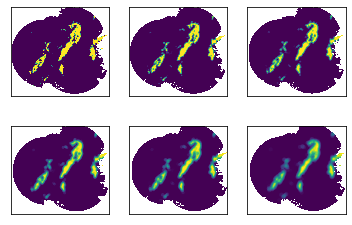

In [4]:
from datetime import datetime

from pysteps import io, rcparams, utils
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.verification import reldiag_init, reldiag_accum, plot_reldiag

# data source
source = rcparams.data_sources["mch"]
root = rcparams.data_sources["mch"]["root_path"]
fmt = rcparams.data_sources["mch"]["path_fmt"]
pattern = rcparams.data_sources["mch"]["fn_pattern"]
ext = rcparams.data_sources["mch"]["fn_ext"]
timestep = rcparams.data_sources["mch"]["timestep"]
importer_name = rcparams.data_sources["mch"]["importer"]
importer_kwargs = rcparams.data_sources["mch"]["importer_kwargs"]

# read precip field
date = datetime.strptime("201607112100", "%Y%m%d%H%M")
fns = io.find_by_date(date, root, fmt, pattern, ext, timestep, num_prev_files=2)
importer = io.get_method(importer_name, "importer")
precip, __, metadata = io.read_timeseries(fns, importer, **importer_kwargs)
precip, metadata = utils.to_rainrate(precip, metadata)
# precip[np.isnan(precip)] = 0

# motion
motion = dense_lucaskanade(precip)

# parameters
nleadtimes = 6
thr = 1  # mm / h
slope = 1 * timestep  # km / min

# compute probability forecast
extrap_kwargs = dict(allow_nonfinite_values=True)
fct = forecast(
    precip[-1], motion, nleadtimes, thr, slope=slope, extrap_kwargs=extrap_kwargs
)

# plot
for n, frame in enumerate(fct):
    plt.subplot(2, 3, n + 1)
    plt.imshow(frame, interpolation="nearest", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
plt.show()

Let's plot one single leadtime in more detail using the pysteps visualization
functionality.



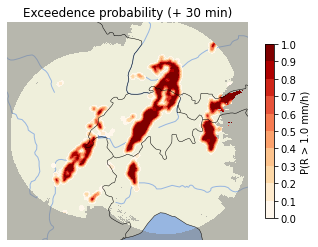

In [5]:
plt.close()
# Plot the field of probabilities
plot_precip_field(
    fct[2],
    geodata=metadata,
    ptype="prob",
    probthr=thr,
    title="Exceedence probability (+ %i min)" % (nleadtimes * timestep),
)
plt.show()

## Verification



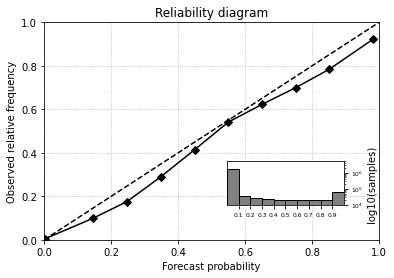

In [6]:
# verifying observations
importer = io.get_method(importer_name, "importer")
fns = io.find_by_date(
    date, root, fmt, pattern, ext, timestep, num_next_files=nleadtimes
)
obs, __, metadata = io.read_timeseries(fns, importer, **importer_kwargs)
obs, metadata = utils.to_rainrate(obs, metadata)
obs[np.isnan(obs)] = 0

# reliability diagram
reldiag = reldiag_init(thr)
reldiag_accum(reldiag, fct, obs[1:])
fig, ax = plt.subplots()
plot_reldiag(reldiag, ax)
ax.set_title("Reliability diagram")
plt.show()

## References
Germann, U. and I. Zawadzki, 2004:
Scale Dependence of the Predictability of Precipitation from Continental
Radar Images. Part II: Probability Forecasts.
Journal of Applied Meteorology, 43(1), 74-89.



In [7]:
# sphinx_gallery_thumbnail_number = 3